# Stability of results wrt random seeds

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import umapns
from firelight.visualizers.colorization import get_distinct_colors
from matplotlib.colors import ListedColormap
import pickle
import matplotlib
from umapns.my_utils import compute_loss_table, get_ring, compute_low_dim_psims
from umapns.my_plot import cut_y_axis
from scipy.sparse import coo_matrix

In [2]:
repeats = 7
data_path_c_elegans = "../data/packer_c-elegans"
data_path_ring = "../data/toy_ring"
fig_path = "../figures"


# C. elegans experiments

In [3]:
# read meta data, obtain colors and ordering of cells that puts special_cell_type to the front and unlabelled cells to
# the back
special_cell_type = "Seam_cell"
meta = pd.read_csv(os.path.join(data_path_c_elegans,
                              "c-elegans_qc_final_metadata.txt"),
                   sep=',',
                   header=0)

cell_types = meta["cell.type"].to_numpy().astype(str)

labels = np.zeros(len(cell_types)).astype(int)
name_to_label = {}
for i, phase in enumerate(np.unique(cell_types)):
    name_to_label[phase] = i
    labels[cell_types==phase] = i

special_cell_label = name_to_label[special_cell_type]
unnamed_label = name_to_label["nan"]

np.random.seed(0)
colors = get_distinct_colors(len(name_to_label))
np.random.shuffle(colors)
colors[special_cell_label] = [0,0,0]
colors[unnamed_label] = [0.5, 0.5, 0.5]
cmap = ListedColormap(colors)

special_order1 = np.argsort(labels == special_cell_label, kind="stable") # put idx of special label to the back
special_order2 = np.argsort(labels[special_order1] != unnamed_label, kind="stable") # put idx of unnamed label to the front
special_order = special_order1[special_order2]
special_order_no_nan = special_order[(labels==unnamed_label).sum():]

In [4]:
# load C. elegans data
pca100 = pd.read_csv(os.path.join(data_path_c_elegans,
                              "c-elegans_qc_final.txt"),
                 sep='\t',
                 header=None)
pca100.shape


(86024, 100)

## Compute loss after full epoch

In [5]:
# can take long, approx repeats * 30 min
umappers_c_elegans_after = []
for repeat in range(repeats):
    try:
        with open(os.path.join(data_path_c_elegans, f"umapperns_after_seed_{repeat}.pkl"), "rb") as file:
            umapper = pickle.load((file))
    except FileNotFoundError:
        umapper= umapns.UMAP(metric="cosine",
                             n_neighbors=30,
                             n_epochs=750,
                             log_losses="after",
                             log_samples=False,
                             random_state=repeat,
                             verbose=True)
        _ = umapper.fit_transform(pca100)
        with open(os.path.join(data_path_c_elegans, f"umapperns_after_seed_{repeat}.pkl"), "wb") as file:
            pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)
    umappers_c_elegans_after.append(umapper)
    print(f"done with run {repeat}")

Wed Apr 21 20:56:31 2021 Building and compiling search function
done with run 0
UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0, log_losses='after',
     metric='cosine', n_epochs=750, n_neighbors=30, random_state=1,
     verbose=True)
Construct fuzzy simplicial set
Wed Apr 21 20:56:33 2021 Finding Nearest Neighbors
Wed Apr 21 20:56:33 2021 Building RP forest with 20 trees
Wed Apr 21 20:56:34 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Wed Apr 21 20:57:00 2021 Finished Nearest Neighbor Search
Wed Apr 21 20:57:03 2021 Construct embedding
	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Wed Apr 21 21:38:42 2021 Finished embedding
Wed Apr 21 21:38:

In [35]:
# compute mean and std of losses over different runs
# actual losses
losses_a = np.array([umapper.aux_data["loss_a"] for umapper in umappers_c_elegans_after])
mean_loss_a = losses_a.mean(axis=0)
std_loss_a = losses_a.std(axis=0)

losses_r = np.array([umapper.aux_data["loss_r"] for umapper in umappers_c_elegans_after])
mean_loss_r = losses_r.mean(axis=0)
std_loss_r = losses_r.std(axis=0)

losses_total = losses_a + losses_r
mean_losses_total = losses_total.mean(axis=0)
std_losses_total = losses_total.std(axis=0)

# purported losses
losses_a_reprod = np.array([umapper.aux_data["loss_a_reprod"] for umapper in umappers_c_elegans_after])
mean_loss_a_reprod = losses_a_reprod.mean(axis=0)
std_loss_a_reprod = losses_a_reprod.std(axis=0)

losses_r_reprod = np.array([umapper.aux_data["loss_r_reprod"] for umapper in umappers_c_elegans_after])
mean_loss_r_reprod = losses_r_reprod.mean(axis=0)
std_loss_r_reprod = losses_r_reprod.std(axis=0)

losses_total_reprod = losses_a_reprod + losses_r_reprod
mean_losses_total_reprod = losses_total_reprod.mean(axis=0)
std_losses_total_reprod = losses_total_reprod.std(axis=0)

# effective losses
losses_a_exp = np.array([umapper.aux_data["loss_a_exp"] for umapper in umappers_c_elegans_after])
mean_loss_a_exp = losses_a_exp.mean(axis=0)
std_loss_a_exp = losses_a_exp.std(axis=0)

losses_r_exp = np.array([umapper.aux_data["loss_r_exp"] for umapper in umappers_c_elegans_after])
mean_loss_r_exp = losses_r_exp.mean(axis=0)
std_loss_r_exp = losses_r_exp.std(axis=0)

losses_total_exp = losses_a_exp + losses_r_exp
mean_losses_total_exp = losses_total_exp.mean(axis=0)
std_losses_total_exp = losses_total_exp.std(axis=0)


mean_losses = [
    [mean_loss_a, mean_loss_r, mean_losses_total],
    [mean_loss_a_exp, mean_loss_r_exp, mean_losses_total_exp],
    [mean_loss_a_reprod, mean_loss_r_reprod, mean_losses_total_reprod]
]

std_losses = [
    [std_loss_a, std_loss_r, std_losses_total],
    [std_loss_a_exp, std_loss_r_exp, std_losses_total_exp],
    [std_loss_a_reprod, std_loss_r_reprod, std_losses_total_reprod]
]

loss_methods = ["actual", "effective", "purported"]
loss_types = ["attractive", "repulsive", "total"]



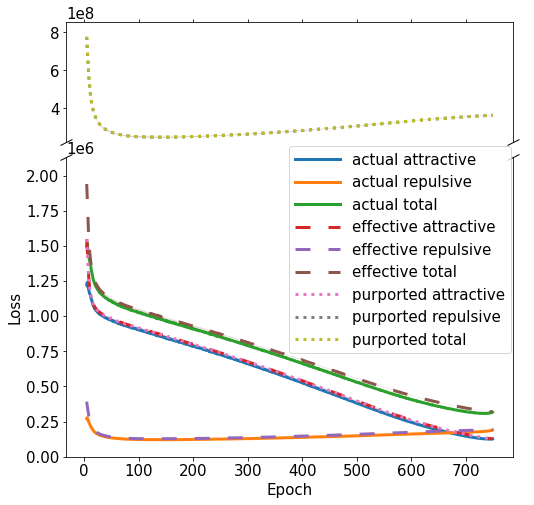

In [36]:
# plot mean loss curves with std dev
start = 5
matplotlib.rcParams.update({'font.size': 15})
fig1 = cut_y_axis(mean_losses,
           loss_methods,
           loss_types,
           std_losses,
           start=start)
fig1.savefig(os.path.join(fig_path, f"c_elegans_after_losses_std_1.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

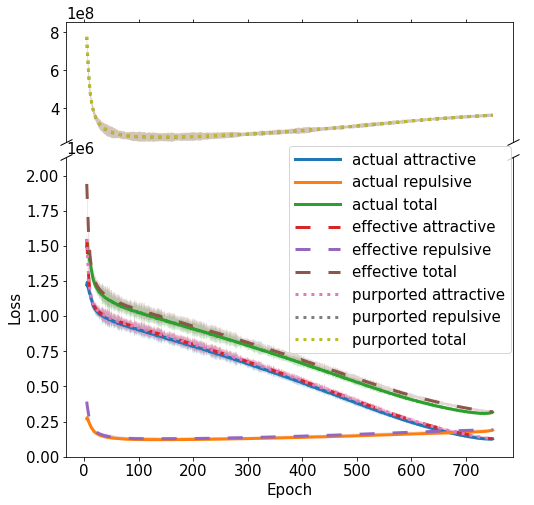

In [37]:
# plot mean loss curves with exaggerated std dev
matplotlib.rcParams.update({'font.size': 15})
fig10 = cut_y_axis(mean_losses,
           loss_methods,
           loss_types,
           10 * np.array(std_losses),
           start=start)
fig10.savefig(os.path.join(fig_path, f"c_elegans_after_losses_std_10.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

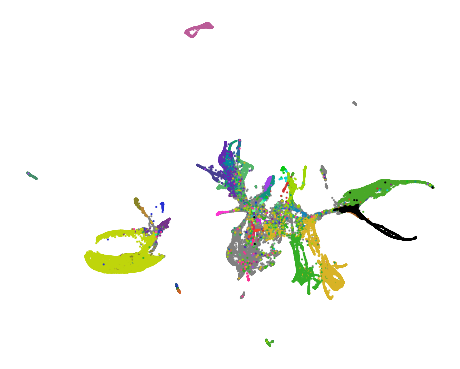

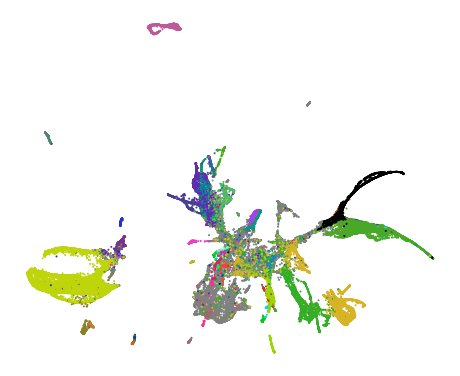

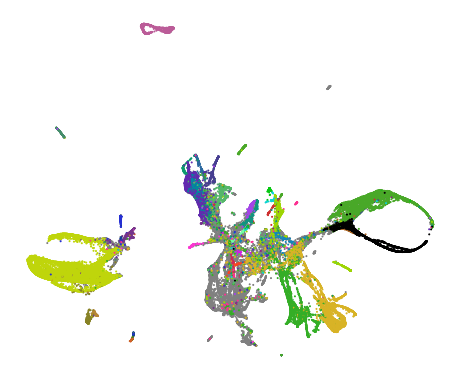

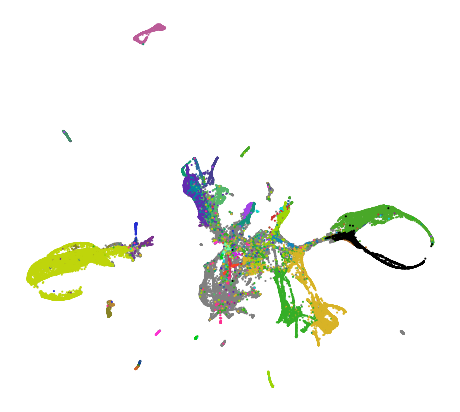

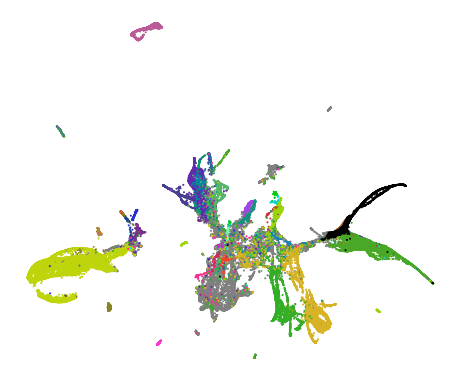

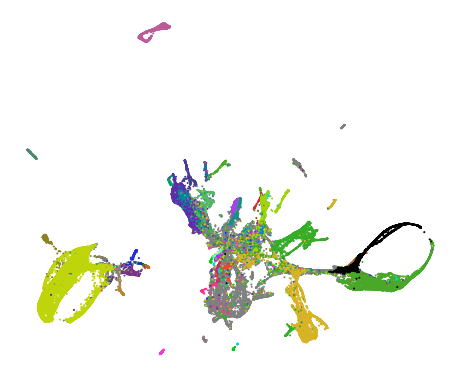

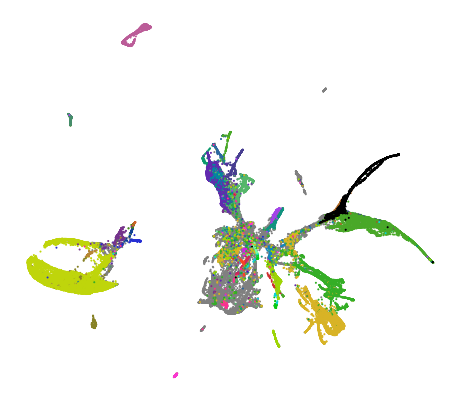

In [9]:
# plot and save embeddings of different runs
plt.figure(figsize=(8,8))
scatter = plt.scatter(- umappers_c_elegans_after[0].embedding_[special_order].T[1],
                      - umappers_c_elegans_after[0].embedding_[special_order].T[0],
                      c=labels[special_order],
                      s=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_after_seed_0.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)


plt.figure(figsize=(8,8))
scatter = plt.scatter(umappers_c_elegans_after[1].embedding_[special_order].T[1],
                      umappers_c_elegans_after[1].embedding_[special_order].T[0],
                      c=labels[special_order],
                      s=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_after_seed_1.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

plt.figure(figsize=(8,8))
scatter = plt.scatter(- umappers_c_elegans_after[2].embedding_[special_order].T[1],
                      - umappers_c_elegans_after[2].embedding_[special_order].T[0],
                      c=labels[special_order],
                      s=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_after_seed_2.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

plt.figure(figsize=(8,8))
scatter = plt.scatter(umappers_c_elegans_after[3].embedding_[special_order].T[1],
                      umappers_c_elegans_after[3].embedding_[special_order].T[0],
                      c=labels[special_order],
                      s=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_after_seed_3.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

plt.figure(figsize=(8,8))
scatter = plt.scatter(- umappers_c_elegans_after[4].embedding_[special_order].T[1],
                      - umappers_c_elegans_after[4].embedding_[special_order].T[0],
                      c=labels[special_order],
                      s=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_after_seed_4.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

plt.figure(figsize=(8,8))
scatter = plt.scatter(- umappers_c_elegans_after[5].embedding_[special_order].T[1],
                      - umappers_c_elegans_after[5].embedding_[special_order].T[0],
                      c=labels[special_order],
                      s=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_after_seed_5.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

plt.figure(figsize=(8,8))
scatter = plt.scatter(umappers_c_elegans_after[6].embedding_[special_order].T[1],
                      umappers_c_elegans_after[6].embedding_[special_order].T[0],
                      c=labels[special_order],
                      s=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_after_seed_6.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

## Loss during epoch

In [10]:
# compute UMAP instances for various random seeds
# can take long, approx repeats * 30 min
umappers_c_elegans_during = []

for repeat in range(repeats):
    try:
        with open(os.path.join(data_path_c_elegans, f"umapperns_during_seed_{repeat}.pkl"), "rb") as file:
            umapper = pickle.load((file))
    except FileNotFoundError:
        umapper= umapns.UMAP(metric="cosine",
                             n_neighbors=30,
                             n_epochs=750,
                             log_losses="during",
                             log_samples=False,
                             random_state=repeat,
                             verbose=True)
        _ = umapper.fit_transform(pca100)
        with open(os.path.join(data_path_c_elegans, f"umapperns_during_seed_{repeat}.pkl"), "wb") as file:
            pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)
    umappers_c_elegans_during.append(umapper)
    print(f"done with run {repeat}")

Thu Apr 22 01:14:55 2021 Building and compiling search function
done with run 0
UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0,
     log_losses='during', metric='cosine', n_epochs=750, n_neighbors=30,
     random_state=1, verbose=True)
Construct fuzzy simplicial set
Thu Apr 22 01:14:56 2021 Finding Nearest Neighbors
Thu Apr 22 01:14:56 2021 Building RP forest with 20 trees
Thu Apr 22 01:14:56 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Thu Apr 22 01:15:13 2021 Finished Nearest Neighbor Search
Thu Apr 22 01:15:15 2021 Construct embedding
	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Thu Apr 22 01:48:39 2021 Finished embedding
Thu Apr 22 01:48

In [40]:
# compute mean and std of losses over different runs
# actual losses
losses_a = np.array([umapper.aux_data["loss_a"] for umapper in umappers_c_elegans_during])
mean_loss_a = losses_a.mean(axis=0)
std_loss_a = losses_a.std(axis=0)

losses_r = np.array([umapper.aux_data["loss_r"] for umapper in umappers_c_elegans_during])
mean_loss_r = losses_r.mean(axis=0)
std_loss_r = losses_r.std(axis=0)

losses_total = losses_a + losses_r
mean_losses_total = losses_total.mean(axis=0)
std_losses_total = losses_total.std(axis=0)

# purported losses
losses_a_reprod = np.array([umapper.aux_data["loss_a_reprod"] for umapper in umappers_c_elegans_during])
mean_loss_a_reprod = losses_a_reprod.mean(axis=0)
std_loss_a_reprod = losses_a_reprod.std(axis=0)

losses_r_reprod = np.array([umapper.aux_data["loss_r_reprod"] for umapper in umappers_c_elegans_during])
mean_loss_r_reprod = losses_r_reprod.mean(axis=0)
std_loss_r_reprod = losses_r_reprod.std(axis=0)

losses_total_reprod = losses_a_reprod + losses_r_reprod
mean_losses_total_reprod = losses_total_reprod.mean(axis=0)
std_losses_total_reprod = losses_total_reprod.std(axis=0)

# effective losses
losses_a_exp = np.array([umapper.aux_data["loss_a_exp"] for umapper in umappers_c_elegans_during])
mean_loss_a_exp = losses_a_exp.mean(axis=0)
std_loss_a_exp = losses_a_exp.std(axis=0)

losses_r_exp = np.array([umapper.aux_data["loss_r_exp"] for umapper in umappers_c_elegans_during])
mean_loss_r_exp = losses_r_exp.mean(axis=0)
std_loss_r_exp = losses_r_exp.std(axis=0)

losses_total_exp = losses_a_exp + losses_r_exp
mean_losses_total_exp = losses_total_exp.mean(axis=0)
std_losses_total_exp = losses_total_exp.std(axis=0)


mean_losses = [
    [mean_loss_a, mean_loss_r, mean_losses_total],
    [mean_loss_a_exp, mean_loss_r_exp, mean_losses_total_exp],
    [mean_loss_a_reprod, mean_loss_r_reprod, mean_losses_total_reprod]
]

std_losses = [
    [std_loss_a, std_loss_r, std_losses_total],
    [std_loss_a_exp, std_loss_r_exp, std_losses_total_exp],
    [std_loss_a_reprod, std_loss_r_reprod, std_losses_total_reprod]
]

loss_methods = ["actual", "effective", "purported"]
loss_types = ["attractive", "repulsive", "total"]



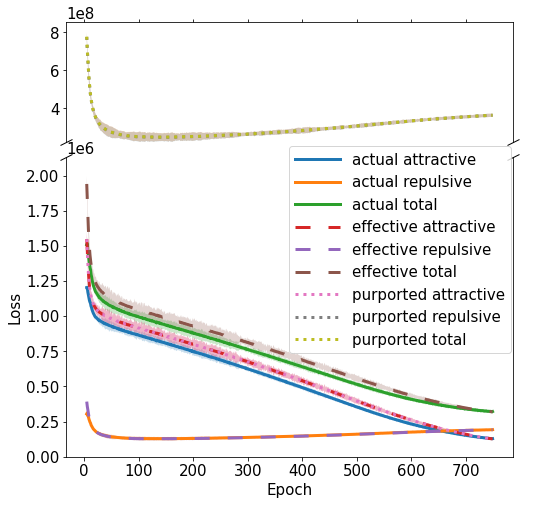

In [42]:
# plot mean losses and std dev
start = 5
matplotlib.rcParams.update({'font.size': 15})
fig1 = cut_y_axis(mean_losses,
           loss_methods,
           loss_types,
           10*np.array(std_losses),
           start=start)
#fig1.savefig(os.path.join(fig_path, f"c_elegans_during_losses_std_1.png"),
#            bbox_inches = 'tight',
#            pad_inches = 0,dpi=300)

# Toy ring

## Use random seed both for resampling the data and for the UMAP instance

In [13]:
# compute UMAP instances for various random seeds
umappers_init_10000_resample_data = []
data_samples = []

for repeat in range(repeats):
    try:
        data = np.load(os.path.join(data_path_ring, f"toy_ring_1000_4_0_5_original_seed_{repeat}.npy"))
    except FileNotFoundError:
        np.random.seed(repeat)
        data = get_ring(1000, 4, 0.5, noise="uniform")  # n=7000, r = 4, var = 0.5 yiels crisp circle for n_epochs=10000
        np.save(os.path.join(data_path_ring,
                             f"toy_ring_1000_4_0_5_original_seed_{repeat}.npy"),
                data)

    try:
        with open(os.path.join(data_path_ring, f"toy_ring_1000_4_0_5_umapperns_init_10000_seed_{repeat}_{repeat}.pkl"), "rb") as file:
            umapper = pickle.load(file)
    except FileNotFoundError:
        umapper = umapns.UMAP(
            random_state=repeat,
            init=data,
            n_epochs=10000,
            verbose=True)
        _ = umapper.fit_transform(data)
        with open(os.path.join(data_path_ring, f"toy_ring_1000_4_0_5_umapperns_init_10000_seed_{repeat}_{repeat}.pkl"), "wb") as file:
            pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)
    umappers_init_10000_resample_data.append(umapper)
    data_samples.append(data)
    print(f"done with run {repeat}")

UMAP(dens_frac=0.0, dens_lambda=0.0,
     init=array([[-0.20410253,  3.69089559],
       [ 0.05185208,  4.42192034],
       [ 0.10899918,  3.61596417],
       ...,
       [-0.01501308,  3.51870937],
       [-0.23812767,  3.85180267],
       [-0.02971633,  3.58850365]]),
     n_epochs=10000, random_state=0, verbose=True)
Construct fuzzy simplicial set
Thu Apr 22 04:36:19 2021 Finding Nearest Neighbors
Thu Apr 22 04:36:21 2021 Finished Nearest Neighbor Search
Thu Apr 22 04:36:22 2021 Construct embedding
	completed  0  /  10000 epochs
	completed  1000  /  10000 epochs
	completed  2000  /  10000 epochs
	completed  3000  /  10000 epochs
	completed  4000  /  10000 epochs
	completed  5000  /  10000 epochs
	completed  6000  /  10000 epochs
	completed  7000  /  10000 epochs
	completed  8000  /  10000 epochs
	completed  9000  /  10000 epochs
Thu Apr 22 04:37:12 2021 Finished embedding
done with run 0
UMAP(dens_frac=0.0, dens_lambda=0.0,
     init=array([[ 0.28694399,  3.85195051],
       [-0.245

In [14]:
losses_init_10000_resample_data = []
for umapper, data in zip(umappers_init_10000_resample_data, data_samples):
    losses_init_10000_resample_data.append(compute_loss_table(umapper, data))

# turn list of dicts into dict of lists and select only the total loss
losses_init_10000_resample_data = {k: [dic[k][-1] for dic in losses_init_10000_resample_data] for k in losses_init_10000_resample_data[0]}

In [15]:
mean_losses_init_10000_resample_data = {k: np.array(losses_init_10000_resample_data[k]).mean() for k in losses_init_10000_resample_data.keys() }
std_losses_init_10000_resample_data = {k: np.array(losses_init_10000_resample_data[k]).std() for k in losses_init_10000_resample_data.keys() }

In [16]:
print(mean_losses_init_10000_resample_data)
print(std_losses_init_10000_resample_data)


{'loss_high_high': 6913.633131981008, 'loss_high_0': 62959.03523399779, 'loss_high_low_embd': 70235.1841686147, 'loss_high_low_data': 136329.36182897392, 'eff_loss_target': 1523.1673860738597, 'eff_loss_0': 54017.438334645805, 'eff_loss_low_embd': 3388.1883235283617, 'eff_loss_low_data': 4972.791281803703}
{'loss_high_high': 41.46370670289876, 'loss_high_0': 81.88353232605073, 'loss_high_low_embd': 1300.731025064961, 'loss_high_low_data': 720.8968344462679, 'eff_loss_target': 6.655435110570669, 'eff_loss_0': 82.29294972648631, 'eff_loss_low_embd': 23.448527446666453, 'eff_loss_low_data': 27.833160452279536}


### Dense input similarities

In [17]:
# get parameters a, b
min_dist = 0.1
spread = 1.0
a, b= umapns.umap_.find_ab_params(spread=spread, min_dist=min_dist)

In [18]:
# compute UMAP instances for several random seeds
umappers_init_graph_10000_resample_data = []

for repeat in range(repeats):
    try:
        data = np.load(os.path.join(data_path_ring, f"toy_ring_1000_4_0_5_original_seed_{repeat}.npy"))
    except FileNotFoundError:
        np.random.seed(repeat)
        data = get_ring(1000, 4, 0.5, noise="uniform")  # n=7000, r = 4, var = 0.5 yiels crisp circle for n_epochs=10000
        np.save(os.path.join(data_path_ring,
                             f"toy_ring_1000_4_0_5_original_seed_{repeat}.npy"),
                data)
    try:
        with open(os.path.join(data_path_ring, f"toy_ring_1000_4_0_5_umapperns_init_graph_10000_seed_{repeat}_{repeat}.pkl"), "rb") as file:
            umapper = pickle.load(file)
    except FileNotFoundError:
        low_sim_sparse = coo_matrix(compute_low_dim_psims(data, a, b))
        umapper = umapns.UMAP(
            graph=low_sim_sparse,
            random_state=repeat,
            init=data,
            n_epochs=10000,
            verbose=True)
        _ = umapper.fit_transform(data)
        with open(os.path.join(data_path_ring, f"toy_ring_1000_4_0_5_umapperns_init_graph_10000_seed_{repeat}_{repeat}.pkl"), "wb") as file:
            pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)
    umappers_init_graph_10000_resample_data.append(umapper)
    print(f"done with run {repeat}")

UMAP(dens_frac=0.0, dens_lambda=0.0,
     graph_=<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1000000 stored elements in COOrdinate format>,
     init=array([[-0.20410253,  3.69089559],
       [ 0.05185208,  4.42192034],
       [ 0.10899918,  3.61596417],
       ...,
       [-0.01501308,  3.51870937],
       [-0.23812767,  3.85180267],
       [-0.02971633,  3.58850365]]),
     n_epochs=10000, random_state=0, verbose=True)
Construct fuzzy simplicial set
Thu Apr 22 04:42:08 2021 Construct embedding
	completed  0  /  10000 epochs
	completed  1000  /  10000 epochs
	completed  2000  /  10000 epochs
	completed  3000  /  10000 epochs
	completed  4000  /  10000 epochs
	completed  5000  /  10000 epochs
	completed  6000  /  10000 epochs
	completed  7000  /  10000 epochs
	completed  8000  /  10000 epochs
	completed  9000  /  10000 epochs
Thu Apr 22 05:12:11 2021 Finished embedding
done with run 0
UMAP(dens_frac=0.0, dens_lambda=0.0,
     graph_=<1000x1000 sparse matrix of type

KeyboardInterrupt: 

In [ ]:
# compute all losses
losses_init_graph_10000_resample_data = []
for umapper in umappers_init_graph_10000_resample_data:
    losses_init_graph_10000_resample_data.append(compute_loss_table(umapper, data))

# turn list of dicts into dict of lists and select only the total loss
losses_init_graph_10000_resample_data = {k: [dic[k][-1] for dic in losses_init_graph_10000_resample_data] for k in losses_init_graph_10000_resample_data[0]}

In [ ]:
mean_losses_init_graph_10000_resample_data = {k: np.array(losses_init_graph_10000_resample_data[k]).mean() for k in losses_init_graph_10000_resample_data.keys() }
std_losses_init_graph_10000_resample_data = {k: np.array(losses_init_graph_10000_resample_data[k]).std() for k in losses_init_graph_10000_resample_data.keys() }

In [ ]:
print(mean_losses_init_graph_10000_resample_data)
print(std_losses_init_graph_10000_resample_data)